<a href="https://colab.research.google.com/github/KruglovaKate/Transfer-Learning/blob/main/flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Create Dataset

In [2]:
import zipfile
import os
zip_file = "/content/gdrive/MyDrive/archive.zip"
z = zipfile.ZipFile(zip_file, 'r')
z.extractall()
print(os.listdir())

['.config', 'gdrive', '17flowers', 'sample_data']


In [3]:
from torch.utils.data import DataLoader
from torchvision.datasets import VisionDataset
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor,Resize, Grayscale, Normalize
import matplotlib.pyplot as plt
import zipfile 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
CLASSES_PATHS = {
   
        0: ["/content/17flowers/jpg/0"],
        1: ["/content/17flowers/jpg/1"],
        2: ["/content/17flowers/jpg/2"],
        3: ["/content/17flowers/jpg/3"],
        4: ["/content/17flowers/jpg/4"],
        5: ["/content/17flowers/jpg/5"],
        6: ["/content/17flowers/jpg/6"],
        7: ["/content/17flowers/jpg/7"],
        8: ["/content/17flowers/jpg/8"],
        9: ["/content/17flowers/jpg/9"],
        10: ["/content/17flowers/jpg/10"],
        11: ["/content/17flowers/jpg/11"],
        12: ["/content/17flowers/jpg/12"],
        13: ["/content/17flowers/jpg/13"],
        14: ["/content/17flowers/jpg/14"],
        15: ["/content/17flowers/jpg/15"],
        16: ["/content/17flowers/jpg/16"]
}

In [5]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import glob
import cv2
from torchvision import transforms

class My_class(Dataset):
    def __init__(self,  classes_paths, transforms=None, target_transform=None):
        #print(glob.glob(data_dir))
        self.classes = []
        self.images = []
        self.transform = transforms
        for actual_class in classes_paths:
            if actual_class == 1:
                print("")
            paths = classes_paths[actual_class]
            for path in paths:
                print("Loading " + path)
                for top, dirs, files in os.walk(path):
                    for i, name in enumerate(files):
                        if not os.path.isfile(top + "//" + name):
                            continue
                        try:
                            imag = cv2.imread(top + "//" + name)
                            imag = cv2.cvtColor(imag, cv2.COLOR_BGR2RGB)
                        except Exception:
                            continue
                        
                        self.images.append(imag)
                        self.classes.append(actual_class)
                        image1 = cv2.flip(imag, 0)                                       
                        self.images.append(image1)
                        self.classes.append(actual_class)
                        image2 = cv2.flip(imag, 1) 
                        self.images.append(image2)
                        self.classes.append(actual_class)
                        image3 = cv2.rotate( imag, cv2.ROTATE_90_CLOCKWISE)
                        self.images.append(image3)
                        self.classes.append(actual_class)
                        image4 = cv2.rotate( imag, cv2.ROTATE_90_COUNTERCLOCKWISE)
                        self.images.append(image4)
                        self.classes.append(actual_class)
        self.images, self.classes = np.array(self.images), np.array(self.classes)       

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.transform==None:
           return self.images[idx], self.classes[idx]
        else:
           return self.transform(np.array(self.images[idx])), self.classes[idx]

In [6]:
transforms = transforms.Compose([ToTensor(), Resize([256, 256])])

In [7]:
dataset = My_class(CLASSES_PATHS, transforms)
param = 0.9
dataset_train, dataset_test = torch.utils.data.random_split(dataset, [int(len(dataset)*param), len(dataset)-int(len(dataset)*param)])
train_loader = DataLoader(dataset_train, batch_size=32, shuffle= True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle= True)

Loading /content/17flowers/jpg/0

Loading /content/17flowers/jpg/1
Loading /content/17flowers/jpg/2
Loading /content/17flowers/jpg/3
Loading /content/17flowers/jpg/4
Loading /content/17flowers/jpg/5
Loading /content/17flowers/jpg/6
Loading /content/17flowers/jpg/7
Loading /content/17flowers/jpg/8
Loading /content/17flowers/jpg/9
Loading /content/17flowers/jpg/10
Loading /content/17flowers/jpg/11
Loading /content/17flowers/jpg/12
Loading /content/17flowers/jpg/13
Loading /content/17flowers/jpg/14
Loading /content/17flowers/jpg/15
Loading /content/17flowers/jpg/16


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Feature batch shape: torch.Size([32, 3, 256, 256])
Labels batch shape: torch.Size([32])


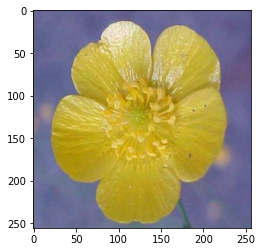

Label: 14


In [8]:
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = np.transpose(img, (2,1,0)) 
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

# CLassic CNN

In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class FourLayerCNN(nn.Module):

    def __init__(self):

        super(FourLayerCNN, self).__init__() 

        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 3, 3)
        self.conv4 = nn.Conv2d(3, 6, 3)
        
        self.fc1 = nn.Linear(22326, 17) 
    

    def forward(self, x):

        x = self.conv1(x) 
        x = F.relu(x)
        x = self.conv2(x) 
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, (2, 2))
        x = torch.flatten(x,1)
        x = self.fc1(x) 
 
        return x     
  


In [10]:
import torch.optim as optim

def validate(model,testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total  

In [11]:
import torch

def train(model, loss_function,optimizer , epochs):
    loss_hist = []
    test_accuracy = []
    train_accuracy = []
    for epoch in range(epochs):
        ep_loss = 0
        for images, labels in train_loader: # get bacth  
            images = images.cuda()
            labels = labels.cuda()       
            optimizer.zero_grad() # sets the gradients of all optimized tensors to zero.
            outputs = model.forward(images) # call forward inside 
            loss = loss_function(outputs, labels) # calculate loss
            loss.backward() # calculate gradients
            optimizer.step() # performs a single optimization step (parameter update).
            ep_loss += loss.item()
        loss_hist.append(ep_loss /len(train_loader))
        print(f"Epoch={epoch} loss={loss_hist[epoch]:.4}")
      #  test_accuracy.append(validate(model, test_loader))
       # train_accuracy.append(validate(model, train_loader))
    return  loss_hist

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = FourLayerCNN().to(device)  # Create model instance
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)  # Weight update
loss_hist_CNN = train(model,  nn.CrossEntropyLoss().cuda(), optimizer, epochs = 10)

Using device: cuda
Epoch=0 loss=2.835
Epoch=1 loss=2.672
Epoch=2 loss=2.189
Epoch=3 loss=2.073
Epoch=4 loss=2.011
Epoch=5 loss=1.933
Epoch=6 loss=1.866
Epoch=7 loss=1.809
Epoch=8 loss=1.713
Epoch=9 loss=1.603


In [13]:
epochs = 10
def test(new_model, loss_function, epochs =10):
  correct = 0
  total = 0
  loss_test = []
  for epoch in range(epochs):
        ep_loss = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.cuda()
                labels = labels.cuda()
          # calculate outputs by running images through the network
                outputs = new_model(images)
                loss = loss_function(outputs, labels)
                ep_loss += loss.item()
          # the class with the highest energy is what we choose as prediction
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        loss_test.append(ep_loss /len(test_loader))
        print(f"Epoch={epoch} loss={loss_test[epoch]:.4}")
  print('Accuracy of the network on the 10000 test images: %d %%' % (
      100 * correct / total))
  return loss_test

In [15]:
loss_test = test(model, nn.CrossEntropyLoss(), epochs = 10)

Epoch=0 loss=1.923
Epoch=1 loss=1.882
Epoch=2 loss=1.911
Epoch=3 loss=1.916
Epoch=4 loss=1.905
Epoch=5 loss=1.882
Epoch=6 loss=1.887
Epoch=7 loss=1.887
Epoch=8 loss=1.894
Epoch=9 loss=1.873
Accuracy of the network on the 10000 test images: 38 %


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
model = FourLayerCNN().to(device)  # Create model instance
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay = 0.001)  # Weight update
loss_hist_CNN_L2 = train(model,  nn.CrossEntropyLoss().cuda(), optimizer, epochs = 10)

Using device: cuda
Epoch=0 loss=2.656
Epoch=1 loss=2.182
Epoch=2 loss=2.021
Epoch=3 loss=1.831
Epoch=4 loss=1.725
Epoch=5 loss=1.642
Epoch=6 loss=1.562
Epoch=7 loss=1.481
Epoch=8 loss=1.441
Epoch=9 loss=1.271


In [17]:
loss_test = test(model, nn.CrossEntropyLoss(), epochs = 10)

Epoch=0 loss=2.039
Epoch=1 loss=2.018
Epoch=2 loss=2.029
Epoch=3 loss=2.044
Epoch=4 loss=2.01
Epoch=5 loss=2.033
Epoch=6 loss=2.067
Epoch=7 loss=2.04
Epoch=8 loss=2.04
Epoch=9 loss=2.031
Accuracy of the network on the 10000 test images: 38 %


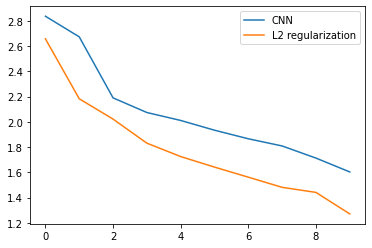

In [18]:
x = [0,1,2,3,4,5,6,7,8,9]
plt.plot(x,loss_hist_CNN, label = 'CNN')
plt.plot(x, loss_hist_CNN_L2, label = 'L2 regularization')
plt.legend()
plt.show()

# Pretrained models


In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import datasets, models, transforms
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy


# Transfer Learning

In [ ]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 17)

model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001)


In [ ]:
loss_hist_tl = train(model_conv, criterion.cuda(), optimizer_conv, epochs=10)

Epoch=0 loss=2.696
Epoch=1 loss=2.23
Epoch=2 loss=1.863
Epoch=3 loss=1.585
Epoch=4 loss=1.369
Epoch=5 loss=1.202
Epoch=6 loss=1.07
Epoch=7 loss=0.9689
Epoch=8 loss=0.8781
Epoch=9 loss=0.8224


In [ ]:
loss_test = test(model_conv, nn.CrossEntropyLoss().cuda(), epochs = 10)

Epoch=0 loss=0.845
Epoch=1 loss=0.8719
Epoch=2 loss=0.8385
Epoch=3 loss=0.8489
Epoch=4 loss=0.8528
Epoch=5 loss=0.8536
Epoch=6 loss=0.852
Epoch=7 loss=0.8589
Epoch=8 loss=0.8435
Epoch=9 loss=0.8724
Accuracy of the network on the 10000 test images: 88 %


# Fine Tuning

In [ ]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 17)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loss_hist_ft_1 = train(model_ft, criterion.cuda(), optimizer_ft, epochs=10)

Epoch=0 loss=1.553
Epoch=1 loss=0.6033
Epoch=2 loss=0.4161
Epoch=3 loss=0.3357
Epoch=4 loss=0.2868
Epoch=5 loss=0.2447
Epoch=6 loss=0.2264
Epoch=7 loss=0.2092
Epoch=8 loss=0.1925
Epoch=9 loss=0.1731


In [ ]:
loss_test = test(model_ft, nn.CrossEntropyLoss().cuda(), epochs = 10)

Epoch=0 loss=0.2437
Epoch=1 loss=0.2324
Epoch=2 loss=0.259
Epoch=3 loss=0.2299
Epoch=4 loss=0.2432
Epoch=5 loss=0.2373
Epoch=6 loss=0.2609
Epoch=7 loss=0.2493
Epoch=8 loss=0.247
Epoch=9 loss=0.2196
Accuracy of the network on the 10000 test images: 95 %


In [ ]:
torch.save(model_ft, 'model_frozen.pt')

In [ ]:
model_ft_new = torch.load('model_frozen.pt')
model_ft_new.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
ct = 0
for child in model_ft_new.children():
  print(child)
  ct += 1
  if ct < 7:
      for param in child.parameters():
          param.requires_grad = False
  else:
      for param in child.parameters():
          param.requires_grad = True

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
loss_hist_ft_2 = train(model_ft_new, criterion.cuda(), optimizer_ft, epochs=10)

Epoch=0 loss=0.127
Epoch=1 loss=0.1266
Epoch=2 loss=0.1272
Epoch=3 loss=0.1269
Epoch=4 loss=0.1264
Epoch=5 loss=0.1277
Epoch=6 loss=0.1265
Epoch=7 loss=0.1265
Epoch=8 loss=0.1267
Epoch=9 loss=0.127


In [ ]:
loss_test = test(model_ft_new, nn.CrossEntropyLoss().cuda(), epochs = 10)

Epoch=0 loss=0.1908
Epoch=1 loss=0.1954
Epoch=2 loss=0.1922
Epoch=3 loss=0.2042
Epoch=4 loss=0.1894
Epoch=5 loss=0.1956
Epoch=6 loss=0.1943
Epoch=7 loss=0.1957
Epoch=8 loss=0.1886
Epoch=9 loss=0.1899
Accuracy of the network on the 10000 test images: 96 %


In [ ]:
torch.save(model_ft_new, 'model_frozen_new.pt')

In [ ]:
model_ft_new_2 = torch.load('model_frozen_new.pt')
model_ft_new_2.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
ct = 0
for child in model_ft_new_2.children():
  print(child)
  ct += 1
  if ct < 2:
      for param in child.parameters():
          param.requires_grad = True
  else:
      for param in child.parameters():
          param.requires_grad = True

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
ReLU(inplace=True)
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
loss_hist_ft_3 = train(model_ft_new_2, criterion.cuda(), optimizer_ft, epochs=10)

Epoch=0 loss=0.1268
Epoch=1 loss=0.1267
Epoch=2 loss=0.1265
Epoch=3 loss=0.1271
Epoch=4 loss=0.1273
Epoch=5 loss=0.1272
Epoch=6 loss=0.1269
Epoch=7 loss=0.1273
Epoch=8 loss=0.1274
Epoch=9 loss=0.1269


In [ ]:
loss_test = test(model_ft_new_2, nn.CrossEntropyLoss().cuda(), epochs = 10)

Epoch=0 loss=0.2042
Epoch=1 loss=0.1947
Epoch=2 loss=0.192
Epoch=3 loss=0.1928
Epoch=4 loss=0.2053
Epoch=5 loss=0.1916
Epoch=6 loss=0.2009
Epoch=7 loss=0.1969
Epoch=8 loss=0.1929
Epoch=9 loss=0.1914
Accuracy of the network on the 10000 test images: 96 %


Fine tuning without frozen layers

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 17)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
loss_hist_ft_0 = train(model_ft, criterion.cuda(), optimizer_ft, epochs=10)

Epoch=0 loss=0.8877
Epoch=1 loss=0.1518
Epoch=2 loss=0.07108
Epoch=3 loss=0.04382
Epoch=4 loss=0.03008
Epoch=5 loss=0.02089
Epoch=6 loss=0.01863
Epoch=7 loss=0.01372
Epoch=8 loss=0.01299
Epoch=9 loss=0.01106


In [ ]:
loss_test = test(model_ft, nn.CrossEntropyLoss().cuda(), epochs = 10)

Epoch=0 loss=0.04018
Epoch=1 loss=0.04249
Epoch=2 loss=0.04512
Epoch=3 loss=0.06806
Epoch=4 loss=0.03992
Epoch=5 loss=0.04511
Epoch=6 loss=0.04492
Epoch=7 loss=0.04745
Epoch=8 loss=0.04173
Epoch=9 loss=0.04452
Accuracy of the network on the 10000 test images: 99 %


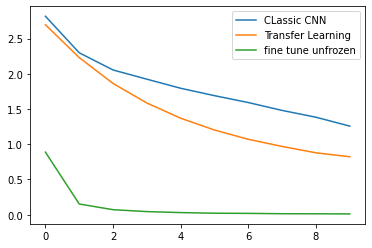

In [ ]:
X = [0,1,2,3,4,5,6,7,8,9]
plt.plot(X, loss_hist_CNN, label = 'CLassic CNN')
plt.plot(X, loss_hist_tl, label = 'Transfer Learning')
plt.plot(X, loss_hist_ft_0, label = 'fine tune unfrozen')
plt.legend()
plt.show()

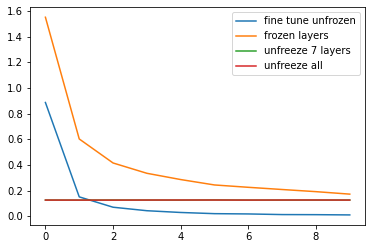

In [ ]:
plt.plot(X, loss_hist_ft_0, label = 'fine tune unfrozen')
plt.plot(X, loss_hist_ft_1, label = 'frozen layers')
plt.plot(X, loss_hist_ft_2, label = 'unfreeze 7 layers')
plt.plot(X, loss_hist_ft_3, label = 'unfreeze all')
plt.legend()
plt.show()